In [ ]:
%cd ~/user_data/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base
%pwd

/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base


'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base'

In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
import cv2
from pycocotools.coco import COCO
from transformers import pipeline
from transformers import Owlv2ImageProcessor, Owlv2Processor, Owlv2ForObjectDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import pandas as pd
import glob

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

/home/DREXEL/jw3897/miniconda3/envs/owlvit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [4]:
val_image_dir = r'/mnt/active_storage/Joe/coco_set/val2017/images'
val_annotation_path = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/ovd_ins_val2017_t.json'

coco_val_dataset = CocoDetection(
    root=val_image_dir, 
    annFile=val_annotation_path,
)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [5]:
print(len(coco_val_dataset))

2064


In [6]:
ovd_image_ids = []
for item in coco_val_dataset:
    ovd_image_ids.append(item[1][0]['image_id'])

print(len(ovd_image_ids))

2064


In [7]:
# image_filenames = os.listdir(val_image_dir)
# image_filenames.sort()

# image_ids = []
# for image_filename in image_filenames:
#     image_id = image_filename.split('.')[0].lstrip('0')
#     image_ids.append(image_id)

In [7]:
category_names = ['airplane', 'bus', 'cat', 'dog', 'cow', 'elephant', 'umbrella', \
    'tie', 'snowboard', 'skateboard', 'cup', 'knife', 'cake', 'couch', 'keyboard', \
    'sink', 'scissors']

In [8]:
category_ids = coco_val_dataset.coco.loadCats(coco_val_dataset.coco.getCatIds())

targets = []
target_boxes = []
target_labels = []

for idx, image_tuple in enumerate(coco_val_dataset):
    image = image_tuple[0]
    annotations = image_tuple[1]
    
    for annotation in annotations:
        label_name = [category['name'] for category in category_ids if category['id'] == annotation['category_id']][0]

        try:
            label = category_names.index(label_name)
        except ValueError as e:
            # If the annotation is not part of the base categories, skip it
            continue

        # xmin, ymin, width, height -> xmin, ymin, xmax, ymax
        box = annotation['bbox']
        bbox = []
        bbox.append(int(round(box[0])))
        bbox.append(int(round(box[1])))
        bbox.append(int(round(box[0] + box[2])))
        bbox.append(int(round(box[1] + box[3])))

        target_boxes.append(bbox)
        target_labels.append(label)

    target_boxes = torch.tensor(target_boxes, dtype=torch.int)
    target_labels = torch.tensor(target_labels, dtype=torch.int)

    target_image_dict = {
        'image_id': ovd_image_ids[idx],
        'boxes': target_boxes,
        'labels': target_labels
    }

    targets.append(target_image_dict)

    # Clear boxes and labels
    target_boxes = []
    target_labels = []

# Evaluation Code

In [9]:
%pwd

'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base'

In [11]:
# prediction_files = glob.glob(r'./grouped_predictions/*.parquet')

# predictions_dfs = []

# for prediction_file in glob.glob(r'./grouped_predictions/*.parquet'):
#     predictions_dfs.append(pd.read_parquet(prediction_file))

# predictions_df_total = pd.concat(predictions_dfs)

# predictions_df_total.sort_values(by=['image_id'], inplace=True)
# predictions_df_total.rename(columns={'label_score': 'score'}, inplace=True)

# predictions_df_total.to_parquet(r'./owlv2_coco_base_predictions.parquet')

predictions_df_total = pd.read_parquet(r'/mnt/active_storage/Joe/owlvit_results/unknown_objects_updated_with_novel_labels_obj2_cls1_clipvitbase32.parquet')

In [12]:
display(predictions_df_total)

,image_id,label,score,objectness_score,xmin,ymin,xmax,ymax
55279,1503,knife,0.276153,0.369445,96.540100,103.998489,120.847557,161.302979
55594,1503,sink,0.471443,0.245349,134.416107,111.131279,205.046005,159.928574
55938,1503,keyboard,0.994812,0.269581,0.308208,130.165726,317.193298,240.838318
55196,1503,tie,0.375620,0.404980,279.463531,93.532410,320.128601,152.998123
54411,1503,knife,0.464695,0.263020,268.243256,6.110020,295.819580,101.931030
...,...,...,...,...,...,...,...,...
167589,581357,tie,0.367143,0.234230,25.962440,337.826660,107.538383,359.686493
168248,581357,tie,0.203935,0.646139,49.977936,327.986267,123.944717,518.138794
166413,581357,cake,0.324012,0.302958,316.926239,114.625443,362.680420,152.093796
167888,581357,umbrella,0.263183,0.206565,61.052029,328.466461,102.281570,410.364929


In [64]:
objectness_threshold = 0.2
score_threshold = 0.1
min_dim = 20

relevant_image_objects = predictions_df_total.loc[predictions_df_total['image_id'].isin(ovd_image_ids)]

confident_objects = relevant_image_objects[relevant_image_objects['score'] >= score_threshold]
unconfident_objects = relevant_image_objects[relevant_image_objects['score'] < score_threshold]

confident_objects_sizelimited = confident_objects[((confident_objects['xmax'] - confident_objects['xmin']) > min_dim) & ((confident_objects['ymax'] - confident_objects['ymin']) > min_dim)]

display(confident_objects_sizelimited)
display(unconfident_objects)

print(f"Number of Confident Annotations: {len(confident_objects)}\n \
Number of Confident Annotations Sizelimited: {len(confident_objects_sizelimited)}\n \
Number of Unconfident Annotations: {len(unconfident_objects)}")

,image_id,label,score,objectness_score,xmin,ymin,xmax,ymax
55279,1503,knife,0.276153,0.369445,96.540100,103.998489,120.847557,161.302979
55594,1503,sink,0.471443,0.245349,134.416107,111.131279,205.046005,159.928574
55938,1503,keyboard,0.994812,0.269581,0.308208,130.165726,317.193298,240.838318
55196,1503,tie,0.375620,0.404980,279.463531,93.532410,320.128601,152.998123
54411,1503,knife,0.464695,0.263020,268.243256,6.110020,295.819580,101.931030
...,...,...,...,...,...,...,...,...
167589,581357,tie,0.367143,0.234230,25.962440,337.826660,107.538383,359.686493
168248,581357,tie,0.203935,0.646139,49.977936,327.986267,123.944717,518.138794
166413,581357,cake,0.324012,0.302958,316.926239,114.625443,362.680420,152.093796
167888,581357,umbrella,0.263183,0.206565,61.052029,328.466461,102.281570,410.364929


,image_id,label,score,objectness_score,xmin,ymin,xmax,ymax


Number of Confident Annotations: 15285
 Number of Confident Annotations Sizelimited: 11539
 Number of Unconfident Annotations: 0


In [65]:
predictions_dict = confident_objects_sizelimited.to_dict('records')

In [66]:
print(len(predictions_dict))

11539


In [67]:
preds = []
pred_boxes = []
pred_scores = []
pred_objectness_scores = []
pred_labels = []

current_img_id = predictions_dict[0]['image_id']
for prediction in predictions_dict:
    # If on a new image...
    if prediction['image_id'] != current_img_id:
        # Convert boxes, scores, and labels to tensors
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
        pred_scores = torch.tensor(pred_scores, dtype=torch.float)
        pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
        pred_labels = torch.tensor(pred_labels, dtype=torch.int)

        # Create the dict for preds
        pred_image_dict = {
            'image_id': current_img_id,
            'boxes': pred_boxes,
            'scores': pred_scores,
            'objectness_scores': pred_objectness_scores,
            'labels': pred_labels
        }

        preds.append(pred_image_dict)

        # Clear boxes, scores, and labels for the new image
        pred_boxes = []
        pred_scores = []
        pred_objectness_scores = []
        pred_labels = []

        # Set new current image id
        current_img_id = prediction['image_id']

    bbox = []
    bbox.append(prediction['xmin'])
    bbox.append(prediction['ymin'])
    bbox.append(prediction['xmax'])
    bbox.append(prediction['ymax'])

    pred_boxes.append(bbox)
    pred_scores.append(prediction['score'])
    pred_objectness_scores.append(prediction['objectness_score'])
    pred_labels.append(category_names.index(prediction['label']))

# Capture the predictions for the last image
pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
pred_scores = torch.tensor(pred_scores, dtype=torch.float)
pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
pred_labels = torch.tensor(pred_labels, dtype=torch.int)

# Create the dict for preds
pred_image_dict = {
    'image_id': current_img_id,
    'boxes': pred_boxes,
    'scores': pred_scores,
    'objectness_scores': pred_objectness_scores,
    'labels': pred_labels
}

preds.append(pred_image_dict)

In [68]:
print(len(preds))

1941


In [69]:
if len(preds) < len(coco_val_dataset):
    pred_image_ids = np.unique([pred['image_id'] for pred in preds])
    missing_ids = list(set(ovd_image_ids) - set(pred_image_ids))
    missing_ids.sort()

    for missing_id in missing_ids:
        missing_id_dict = {
            'image_id': missing_id,
            'boxes': torch.tensor([], dtype=torch.int),
            'scores': torch.tensor([], dtype=torch.float),
            'objectness_scores': torch.tensor([], dtype=torch.float),
            'labels': torch.tensor([], dtype=torch.int),
        }
        preds.insert(ovd_image_ids.index(missing_id), missing_id_dict)

In [70]:
assert len(preds) == len(coco_val_dataset)
for idx in range (len(preds)):
    assert preds[idx]['image_id'] == ovd_image_ids[idx]

In [71]:
for idx in range(len(targets)):
    assert targets[idx]['image_id'] == preds[idx]['image_id']

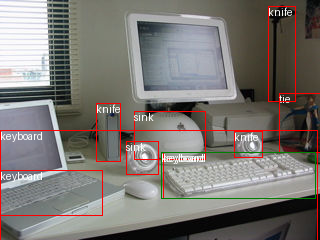

In [72]:
# Visualize some preds and targets
from PIL import ImageDraw

index = 0

visualized_image = coco_val_dataset[index][0].copy()

draw = ImageDraw.Draw(visualized_image)

for box, label in zip(preds[index]['boxes'], preds[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='red')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

for box, label in zip(targets[index]['boxes'], targets[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='green')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

display(visualized_image)

In [73]:
metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_type='bbox',
    iou_thresholds=None, # Defaults to trying from 0.5 -> 0.95 in steps of 0.05 
    rec_thresholds=None,
    max_detection_thresholds=None, # Uses [1, 10, 100]
    class_metrics=False,
    extended_summary=False, # This way, we can see the ious and scores calculated
    average='macro',
    backend='pycocotools'
)

metric.update(preds, targets)

In [74]:
computed_metric = metric.compute()

In [75]:
print(f"Objectness Threshold: {objectness_threshold}; Score Threshold: {score_threshold}; Min Dim: {min_dim}")
print(f"mAP: {round(computed_metric['map'].item(), 4):.4f}\nNum Objects: {len(predictions_dict)}")

Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 20
mAP: 0.1967
Num Objects: 11539


Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 0
mAP: 0.1958
Num Objects: 15285

Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 5
mAP: 0.1958
Num Objects: 15106

Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 10
mAP: 0.1968
Num Objects: 14056

Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 15
mAP: 0.1972
Num Objects: 12878

Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 20
mAP: 0.1967
Num Objects: 11539